# ベイズ勉強会 Part 8 ポアソン混合モデル

> ポアソン混合モデルの近似推論

- toc: true 
- badges: true
- comments: true
- categories: [bayes]
- image: images/dag1.png

ベイズ勉強会資料は『ベイズ推論による機械学習入門』{% fn 1 %}を元に、途中式計算をできるだけ省略せずに行ったものです。

In [1]:
using Distributions
using Plots
using StatsPlots

## 登場する確率分布(再掲)

### カテゴリ分布

カテゴリ分布は次のような確率質量関数を分布関数にもつ確率分布である。

$$
Cat({\bf s}|{\bf \pi}) = \Pi_{k=1}^{K} \pi_k^{s_k}
$$

${\bf s}$はK次元ベクトルで、該当カテゴリのみを1,それ以外を0で表したものである(1 of K 表現)。例えば、サイコロの目を確率変数とすれば$s = 5$と書く代わりに、${\bf s} = (0,0,0,0,1,0)^\mathrm{T}$と書く。パラメータ${\bf \pi} = (\pi_1,\dots,\pi_K)^\mathrm{T}$は各カテゴリに配される確率を表したものであり、$\pi_k \in (0,1)$かつ$\Sigma_{k=1}^{K} \pi_k = 1$を満たす。

対数をとると

$$
\ln Cat({\bf s}|{\bf \pi}) = \Sigma_{k=1}^{K} s_k \ln \pi_k
$$

となる。

### ディリクレ分布

尤度関数にカテゴリ分布をとった場合、パラメータ${\bf \pi}$の事前分布は、$\pi_k \in (0,1)$かつ$\Sigma_{k=1}^{K} \pi_k = 1$を満たすK次元ベクトルを出力する必要がある。このような分布として、ディリクレ分布がある。ディリクレ分布の分布関数は次のようになる。

$$
Dir({\bf \pi}|{\bf \alpha}) = C_D ({\bf \alpha}) \Pi_{k=1}^{K} \pi_k^{\alpha_k - 1}
$$

ディリクレ分布のパラメータ${\bf \alpha} = (\alpha_1, \dots, \alpha_K)^\mathrm{T}$の要素$\alpha_k$は正の実数である。正規化係数は

$$
C_D ({\bf \alpha}) = \frac{\Gamma (\Sigma_{k=1}^{K} \alpha_k)}{\Pi_{k=1}^{K} \Gamma (\alpha_k)}
$$

である。

対数をとると

$$
\ln Dir({\bf \pi}|{\bf \alpha}) = \Sigma_{k=1}^{K} (\alpha_k - 1) \ln \pi_k + \ln C_D ({\bf \alpha})
$$

となる。

### ポアソン分布

ポアソン分布は次のような確率密度関数を分布関数にもつ確率分布である。

$$
\mathrm{Poi} (x|\lambda) = \frac{\lambda^x}{x!} \mathrm{e}^{-\lambda}
$$

xは非負の整数、パラメータ$\lambda$は正の実数である。

対数をとると

$$
\ln \mathrm{Poi} (x|\lambda) = x \ln \lambda - \ln x! - \lambda
$$

である。

### ガンマ分布

ポアソン分布のパラメータ$\lambda$は正の実数であるので、事前分布$p(\lambda)$はガンマ分布で表すと都合が良い。ガンマ分布は次のような確率密度関数を分布関数にもつ確率分布である。

$$
\mathrm{Gam}(\lambda|a,b) = C_G(a,b)\lambda^{a-1} \mathrm{e}^{-b\lambda}
$$

正規化係数$C_G(a,b)$は次のような関数である。

$$
C_G(a,b) = \frac{b^a}{\Gamma(a)}
$$

ガンマ分布の対数をとると

$$
\ln \mathrm{Gam}(\lambda|a,b) = (a-1)\ln \lambda - b\lambda + \ln C_G(a,b)
$$

である。

## モデル構築

これまでは次のような1峰性の分布の密度推定をするモデルを扱ってきた。

$$
\begin{eqnarray}
p({\bf X},\lambda) &=& p({\bf X}|\lambda)p(\lambda) \\
ただし　p({\bf X}) &=& \Pi_{n=1}^{N} \mathrm{Poi}(x_n|\lambda) \\
p(\lambda) &=& \mathrm{Gam}(\lambda|a,b)
\end{eqnarray}
$$

In [6]:
# ポアソン分布による密度推定用のモデル
mutable struct PoisModel
    a::Float64
    b::Float64
end

In [7]:
# 事前予測分布を計算する関数
function predict(model::PoisModel)
    r = model.a
    p = 1 / (model.b + 1)
    predict_dist = NegativeBinomial(r, p)
    return predict_dist
end

predict (generic function with 1 method)

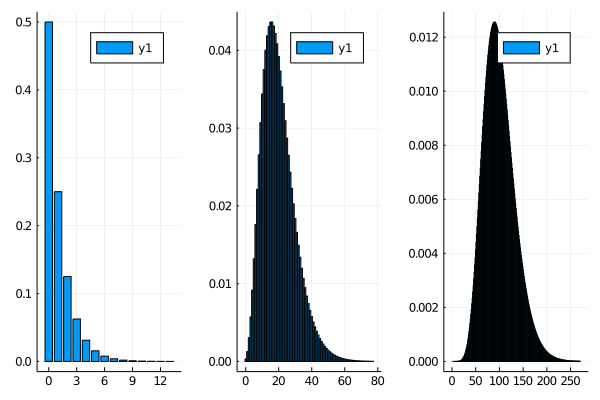

In [21]:
# ハイパーパラメータの値を変えても、1峰性であることは変わらない
p1 = bar(predict(PoisModel(1,1)))
p2 = bar(predict(PoisModel(5,4)))
p3 = bar(predict(PoisModel(10,10)))
plot(p1,p2,p3,layout=(1,3))

このモデルには次のような多峰性の分布を持つデータを表現することができないという欠点がある。

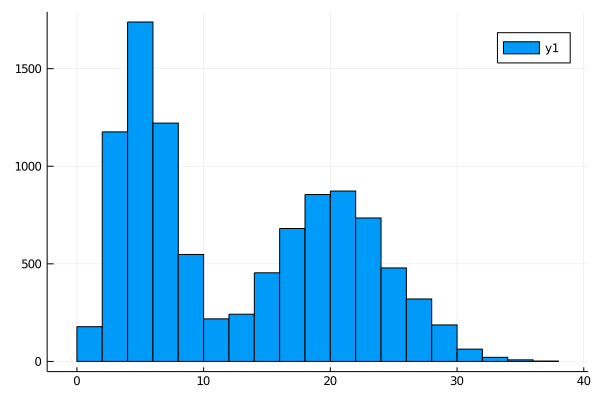

In [45]:
# λ=5とλ=20のポアソン分布から半々の確率で生成したデータ点
Ys = []
for i in 1:10000
    K = rand(Categorical([0.5,0.5]))
    λ = ifelse(K==1,5,20)
    Y = rand(Poisson(λ))
    push!(Ys,Y)
end
histogram(Ys)

そこで、「データを複数のクラスタ(集団)に分けることができ、クラスタごとに異なるポアソン分布から生成されている」という仮定をおいてみることにする。これはカテゴリ分布とポアソン分布を組み合わせることで実現できる。

モデルにおけるN個のデータ点${\bf X} = \{ x_1,\dots,x_N \}$の生成過程を記述すると次(参考資料より引用{% fn 1 %})のようになる。クラスタ数Kは既知とする。

1. それぞれのクラスタの混合比率${\bf \pi} = (\pi_1,\dots,\pi_K)^\mathrm{T}$が事前分布$p({\bf \pi})$から生成される（ただし$\pi_k \in (0,1)$かつ$\Sigma_{k=1}^{K} \pi_k=1$）。
2. それぞれのクラスタ$k=1,\dots,K$に対する観測モデルのパラメータ$\theta_k$（平均や分散）が事前分布$p(\theta_k)$から生成される。
3. $n=1,\dots,N$に関して、$x_n$に対するクラスタの割当$s_n$が比率${\bf \pi}$によって選ばれる。
4. $n=1,\dots,N$に関して、$s_n$によって選択されたk番目の確率分布$p(x_n|\theta_k)$からデータ点$x_n$が生成される。

この生成過程を同時分布の形で書くと次のようになる。$s_n$を1 of K表現で表し、${\bf S} = \{ s_1,\dots,s_N \}$とする。

$$
\begin{eqnarray}
    p({\bf X},{\bf S},{\bf \lambda},{\bf \pi}) &=& p({\bf X}|{\bf S},{\bf \lambda})p({\bf S}|{\bf \pi})p({\bf \lambda})p({\bf \pi}) \\
    &=& \{ \Pi_{n=1}^{N} p(x_n|s_n,{\bf \lambda})p(s_n|{\bf \pi}) \} \{ \Pi_{k=1}^{K} p(\lambda_k) \} p({\bf \pi}) \\
    ただし　p({\bf \pi}) &=& \mathrm{Dir}({\bf \pi}|{\bf \alpha}) \\
    p(\lambda_k) &=& \mathrm{Gam}(\lambda_k|a,b) \\
    p(x_n|s_n,{\bf \lambda}) &=& \Pi_{k=1}^{K} \mathrm{Poi}(x_n|\lambda_k)^{s_{n,k} }
\end{eqnarray}
$$

このようにモデルの生成過程に対する仮定を元に記述したモデルを生成モデルと呼ぶ。また、直接観測されることのないカテゴリ変数$s_n$を隠れ変数または潜在変数と呼ぶ。

## 事後分布の推論

同時分布の形で書いているので、事後分布は観測された変数${\bf X}$の分布で割れば求まる。

$$
p({\bf S},{\bf \lambda},{\bf \pi}|{\bf X}) = \frac{p({\bf X},{\bf S},{\bf \lambda},{\bf \pi})}{p({\bf X})}
$$

しかしこれを計算することは現実的には困難であることが知られている。分母の$p({\bf X})$を計算しようとすると、

$$
\begin{eqnarray}
    p({\bf X}) &=& \Sigma_{S} \int \int p({\bf X},{\bf S},{\bf \lambda},{\bf \pi}) d {\bf \lambda} d {\bf \pi} \\
    &=& \Sigma_{S} p({\bf X},{\bf S})
\end{eqnarray}
$$

を解くことになるが、共役事前分布を使うことによりパラメータ${\bf \lambda},{\bf \pi}$については解析的に積分除去可能になるが、$p({\bf X},{\bf S})$を${\bf S}$のとりうる全ての組み合わせについて計算する必要がある。N個の要素がK個のクラスタに分類されるので$K^N$回計算する必要があり、現実的に不可能な計算量になってしまう。そこでMCMC,変分推論といった近似推論手法を用いる必要がある。

{{ '[須山敦志. 杉山将. ベイズ推論による機械学習入門. 講談社, 2017.](https://www.kspub.co.jp/book/detail/1538320.html)' | fndetail: 1 }}